In [1]:
import pandas as pd
playlist = pd.read_csv('fma-rock-vs-hiphop.csv')
echons = pd.read_json('echonest-metrics.json', precise_float=True)
playlist_echons = echons.merge(playlist[['genre_top', 'track_id']], on='track_id')
playlist_echons.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4802 entries, 0 to 4801
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_id          4802 non-null   int64  
 1   acousticness      4802 non-null   float64
 2   danceability      4802 non-null   float64
 3   energy            4802 non-null   float64
 4   instrumentalness  4802 non-null   float64
 5   liveness          4802 non-null   float64
 6   speechiness       4802 non-null   float64
 7   tempo             4802 non-null   float64
 8   valence           4802 non-null   float64
 9   genre_top         4802 non-null   object 
dtypes: float64(8), int64(1), object(1)
memory usage: 412.7+ KB


In [7]:

corr_metrics = echons.corr()
corr_metrics.style.background_gradient()

In [14]:
import sklearn as sk
features = playlist_echons.drop(columns=['genre_top', 'track_id'])
labels = playlist_echons['genre_top']
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(features)

Text(0.5, 0, 'Principal Component #')

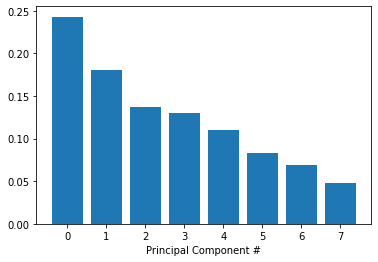

In [15]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

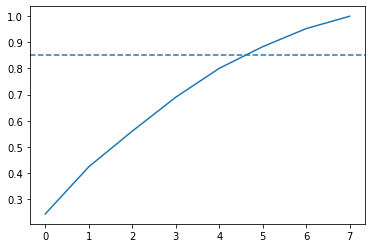

In [16]:
import numpy as np
cum_exp_variance = np.cumsum(exp_variance)
fig, ax = plt.subplots()
ax.plot(cum_exp_variance)
ax.axhline(y=0.85, linestyle='--')
n_components = 6
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

In [19]:

from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)
print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.60      0.60      0.60       235
        Rock       0.90      0.90      0.90       966

    accuracy                           0.84      1201
   macro avg       0.75      0.75      0.75      1201
weighted avg       0.84      0.84      0.84      1201

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.77      0.54      0.64       235
        Rock       0.90      0.96      0.93       966

    accuracy                           0.88      1201
   macro avg       0.83      0.75      0.78      1201
weighted avg       0.87      0.88      0.87      1201



In [25]:
hop_only = playlist_echons.loc[playlist_echons['genre_top'] == 'Hip-Hop']
rock_only = playlist_echons.loc[playlist_echons['genre_top'] == 'Rock']
rock_only = rock_only.sample(hop_only.shape[0], random_state=10)
rock_hop_bal = pd.concat([rock_only, hop_only])
features = rock_hop_bal.drop(['genre_top', 'track_id'], axis=1) 
labels = rock_hop_bal['genre_top']
pca_projection = pca.fit_transform(scaler.fit_transform(features))
train_features, test_features, train_labels, test_labels = train_test_split(
    pca_projection, labels, random_state=10)

In [26]:
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)
# compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))

Decision Tree: 
               precision    recall  f1-score   support

     Hip-Hop       0.74      0.73      0.74       230
        Rock       0.73      0.74      0.73       225

    accuracy                           0.74       455
   macro avg       0.74      0.74      0.74       455
weighted avg       0.74      0.74      0.74       455

Logistic Regression: 
               precision    recall  f1-score   support

     Hip-Hop       0.84      0.80      0.82       230
        Rock       0.80      0.85      0.83       225

    accuracy                           0.82       455
   macro avg       0.82      0.82      0.82       455
weighted avg       0.82      0.82      0.82       455



In [27]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(10)
tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score))


Decision Tree: 0.7489010989010989 Logistic Regression: 0.782967032967033
